# GPT for SMILES strings

This code builds a GTP with attention model that takes as input a list of SMILES strings
and learns the type of chemical structures that it has been fed. It can then generate new molecules with
the language it has learned.

## Tokenizing

This block:

- Loads all needed modules/libraries
    
- reads in the datafile containing the SMILES strings
    
* initiates the SMILES tokenizer from the DeepChem library
    
* determines the vocabulary size (see bottom block for customizing vocabulary)
    
* determines the longest SMILES chain, and then pads all shorter chains so that
    we get uniform length
    
* makes input/target pairs that are each SMILES chain without the last character paired with
the full chain missing the last character.
    
* creates the datasets from the pairs

In [3]:
!pip install deepchem

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import deepchem as dc
import time
import transformers
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split
from deepchem.feat.smiles_tokenizer import SmilesTokenizer

df = pd.read_csv("/content/sample_data/6731-azo.csv")

Xa = [""]*len(df)
w = [""]*len(df)
i=0
for name in df["SMILES"]:
    Xa[i]=name
    w[i]=1.0
    i += 1
Xa = list(Xa)
w=list(w)

#===========================================================================================
#featurize

tokenizer=dc.feat.SmilesTokenizer(vocab_file="/content/sample_data/vocab_new.txt")
featname="SMILES Tokenizer"

fl = list(map(lambda x: tokenizer.encode(x),Xa))

biggest = 1
smallest = 200
for i in range(len(fl)):
    temp = len(fl[i])
    if temp > biggest:
        biggest = temp
    if temp < smallest:
        smallest = temp

print(biggest, smallest)

string_length = smallest - 1
max_length = biggest

fl2 = list(map(lambda x: tokenizer.add_padding_tokens(x,max_length),fl))

fl2set=set()
for sublist in fl2:
    fl2set.update(sublist)
VOCAB_SIZE = len(fl2set)+1 #add one for unused, original vocab list is 591
print("Vocabulary size for this dataset: ",VOCAB_SIZE)
print(fl2set)

xlist = [0]*len(fl2)
ylist = [0]*len(fl2)
i=0
for i in range(len(fl2)):
    xlist[i] = fl2[i][0:max_length-1] #string_length
    ylist[i] = fl2[i][1:max_length] #string_length+1
    i += 1

#print("Sample input and target: ")
#print(xlist[5], ylist[5])
#print(xlist[500], ylist[500])
fx = np.array(xlist)
fy = np.array(ylist)
print("Number of features and datapoints, targets: ",fx.shape,fy.shape)
f=fx
#===========================================================================================
print("featurization done with: ",featname)

# set npp for how many points in the dataset, len(df) for whole dataset
nnp= 6016 #len(df)

#set y to target
y = fy

#set dataset and split

dataset = dc.data.NumpyDataset(X=f[:nnp,:], y=y[:nnp,:], ids=Xa[:nnp], w=w[:nnp])

105 9
Vocabulary size for this dataset:  74
{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73}
Number of features and datapoints, targets:  (6731, 104) (6731, 104)
featurization done with:  SMILES Tokenizer


## Define the casual attention mask function

In [5]:
def casual_attention_mask(batch_size,n_dest,n_src,dtype):
    i = tf.range(n_dest)[:,None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m,dtype)
    mask = tf.reshape(mask,[1,n_dest,n_src])
    mult = tf.concat([tf.expand_dims(batch_size,-1),tf.constant([1,1],dtype=tf.int32)],0)
    return tf.tile(mask,mult)

np.transpose(casual_attention_mask(1,10,10,dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## Define the block layer

- Uses the multihead attention layer from Keras

In [6]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,num_heads,key_dim,embed_dim,ff_dim,dropout_rate=0.1):
        super(TransformerBlock,self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = tf.keras.layers.MultiHeadAttention(self.num_heads,self.key_dim,
                                                       output_shape=self.embed_dim)
        self.dropout_1 = tf.keras.layers.Dropout(self.dropout_rate)
        self.ln_1 = tf.keras.layers.LayerNormalization(epsilon=0.000001)
        self.ffn_1 = tf.keras.layers.Dense(self.ff_dim,activation="relu")
        self.ffn_2 = tf.keras.layers.Dense(self.embed_dim)
        self.dropout_2 = tf.keras.layers.Dropout(self.dropout_rate)
        self.ln_2 = tf.keras.layers.LayerNormalization(epsilon=0.000001)

    def call(self,inputs):
        input_shape = tf.shape(inputs)
        batch_size2 = input_shape[0]
        seq_len = input_shape[1]
        casual_mask = casual_attention_mask(batch_size2,seq_len,seq_len,tf.bool)
        attention_output, attention_scores = self.attn(inputs,inputs,
                                                       attention_mask=casual_mask,
                                                       return_attention_scores=True)
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1+ffn_output),attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update({"key_dim": self.key_dim, "embed_dim": self.embed_dim,
                      "num_heads": self.num_heads,"ff_dim": self.ff_dim,
                      "dropout_rate": self.dropout_rate})
        return config

print("Transformer Block built.")

Transformer Block built.


## Define token and position embedding

In [7]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self,max_len,vocab_size,embed_dim):
        super(TokenAndPositionEmbedding,self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                    output_dim = embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=max_len,output_dim=embed_dim)

    def call(self,x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0,limit=maxlen,delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({"max_len": self.max_len, "vocab_size": self.vocab_size,
                      "embed_dim": self.embed_dim})
        return config

print("Token and position embedding function built.")

Token and position embedding function built.


## Training the model

- This block defines the sequential model and runs the optimization.

- can load previous weights

In [20]:
EMBEDDING_DIM = 256
N_HEADS = 2
KEY_DIM = 256
FEED_FORWARD_DIM = 256
batch_size = 128

inputs = tf.keras.layers.Input(shape=(None,),dtype=tf.int32)
x = TokenAndPositionEmbedding(max_length,VOCAB_SIZE,EMBEDDING_DIM)(inputs)
x, attentions_scores = TransformerBlock(N_HEADS,KEY_DIM,EMBEDDING_DIM,FEED_FORWARD_DIM)(x)
outputs = tf.keras.layers.Dense(VOCAB_SIZE,activation="softmax")(x)

gpt = tf.keras.models.Model(inputs = inputs, outputs =[outputs, attentions_scores])
gpt.compile("adam",loss=[tf.keras.losses.SparseCategoricalCrossentropy(),None])

gpt.load_weights("/content/gpt_11april_2.h5")

gpt.fit(fx,fy,epochs = 150, batch_size = batch_size)

Epoch 1/150
53/53 [==============================] - 8s 57ms/step - loss: 0.2910 - dense_8_loss: 0.2910
Epoch 2/150
53/53 [==============================] - 2s 40ms/step - loss: 0.2783 - dense_8_loss: 0.2783
Epoch 3/150
53/53 [==============================] - 2s 37ms/step - loss: 0.2794 - dense_8_loss: 0.2794
Epoch 4/150
53/53 [==============================] - 2s 38ms/step - loss: 0.2804 - dense_8_loss: 0.2804
Epoch 5/150
53/53 [==============================] - 2s 36ms/step - loss: 0.2803 - dense_8_loss: 0.2803
Epoch 6/150
53/53 [==============================] - 2s 37ms/step - loss: 0.2804 - dense_8_loss: 0.2804
Epoch 7/150
53/53 [==============================] - 2s 36ms/step - loss: 0.2798 - dense_8_loss: 0.2798
Epoch 8/150
53/53 [==============================] - 2s 38ms/step - loss: 0.2788 - dense_8_loss: 0.2788
Epoch 9/150
53/53 [==============================] - 2s 37ms/step - loss: 0.2795 - dense_8_loss: 0.2795
Epoch 10/150
53/53 [==============================] - 2s 40ms/st

## Saves the current model to the current folder

In [21]:
gpt.save_weights("gpt_11april_300epcs.h5")
print("model saved.")

model saved.


## Standard molecule prediction

This block

- Takes two strings from the training set (5 and 6 in this case) to use as "seeds"

- Tokenizes the strings
- Makes the input for the predictor by making 2 inputs with **string_length** characters (string_length
is the length of the shortest string in the input. Can be set to any number)
- predictes a new character with the model (the most probable character) and then adds that to the input string,
so that the input is one character longer.
- uses the new input to predict the next chacacter, etc.

In [42]:
test_string=[""]*2
test_xlist=[0.0]*2

test_string[0] = "CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C"
test_string[1] = "Clc1nnc(c(c1)N1CCN(CC1)CCOc1ccc(cc1)n1cnnc1)Cl"

test_tokenized = list(map(lambda x: tokenizer.encode(x),test_string))
i=0
for i in range(len(test_tokenized)):
    test_xlist[i] = test_tokenized[i][0:4]
    i += 1

test_array = np.array(test_xlist)

print("test array: ",test_array)

for i in range(1,80,1):
    results,att = gpt.predict(test_array)
    #print(len(results))
    first_proba = results[0][-1]
    second_proba = results[1][-1]
    first_pred = tf.argmax(first_proba)
    second_pred = tf.argmax(second_proba)
    test_xlist[0].append(int(first_pred))
    test_xlist[1].append(int(second_pred))
    test_array = np.array(test_xlist)

new_molecule = tokenizer.decode(test_xlist[0])
new_molecule2 = tokenizer.decode(test_xlist[1])
nm1 = tokenizer.convert_tokens_to_string(new_molecule).replace(" ","")
nm2 = tokenizer.convert_tokens_to_string(new_molecule2).replace(" ","")

nm1 = nm1.replace("[CLS]","")
nm1 = nm1.replace("[SEP]","")
nm1 = nm1.replace("[PAD]","")
nm2 = nm2.replace("[CLS]","")
nm2 = nm2.replace("[SEP]","")
nm2 = nm2.replace("[PAD]","")
print(f"New molecules: {nm1} \n {nm2}.")
print("")

test array:  [[ 3  6 13 10]
 [ 3 18  5 10]]
1/1 [==============================] - 0s 21ms/step
New molecules: CN1C(=O)C(=C(C1=O)c1ccc(cc1)N(C)C)c1ccc(cc1)N 
 Clc1ccc(cc1)c1nnc(o1)c1ccco1.



## Temperature-based molecule prediction

This block

- Sets a temperature, which defines how "probable" the next character added to the molecule will be.
- A higher temperature means the next character is less probable.
- Takes two strings from the training set (5 and 6 in this case) to use as "seeds"
- Tokenizes the strings
- Makes the input for the predictor by making 2 inputs with **string_length** characters (string_length
is the length of the shortest string in the input. Can be set to any number)
- predictes a new character with the model (based on the temperature) and then adds that to the input string,
so that the input is one character longer.
- uses the new input to predict the next character, etc.

In [43]:
temp = 0.6
tf.random.set_seed(42)

test_string=[""]*2
test_xlist=[0.0]*2

test_string[0] = "CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C"
test_string[1] = "Clc1nnc(c(c1)N1CCN(CC1)CCOc1ccc(cc1)n1cnnc1)Cl"

test_tokenized = list(map(lambda x: tokenizer.encode(x),test_string))
i=0
for i in range(len(test_tokenized)):
    test_xlist[i] = test_tokenized[i][0:4]
    i += 1

test_array = np.array(test_xlist)
print("test array: ",test_array)

for i in range(1,80,1):
    results,att = gpt.predict(test_array)
    #print(len(results))
    first_proba = results[0][-1]
    second_proba = results[1][-1]

    first_rescaled_logits = first_proba ** (1 / temp)
    first_rescaled_logits = first_rescaled_logits / np.sum(first_rescaled_logits)
    first_pred = np.random.choice(len(first_rescaled_logits), p=first_rescaled_logits)

    second_rescaled_logits = second_proba ** (1 / temp)
    second_rescaled_logits = second_rescaled_logits / np.sum(second_rescaled_logits)
    second_pred = np.random.choice(len(second_rescaled_logits), p=second_rescaled_logits)

    test_xlist[0].append(int(first_pred))
    test_xlist[1].append(int(second_pred))
    test_array = np.array(test_xlist)

new_molecule = tokenizer.decode(test_xlist[0])
new_molecule2 = tokenizer.decode(test_xlist[1])
ntm1 = tokenizer.convert_tokens_to_string(new_molecule).replace(" ","")
ntm2 = tokenizer.convert_tokens_to_string(new_molecule2).replace(" ","")

ntm1 = ntm1.replace("[CLS]","")
ntm1 = ntm1.replace("[SEP]","")
ntm1 = ntm1.replace("[PAD]","")
ntm2 = ntm2.replace("[CLS]","")
ntm2 = ntm2.replace("[SEP]","")
ntm2 = ntm2.replace("[PAD]","")
print(f"New molecules: {ntm1} \n {ntm2}.")
print("")

test array:  [[ 3  6 13 10]
 [ 3 18  5 10]]
1/1 [==============================] - 0s 22ms/step
New molecules: CN1c2ccc(cc2Sc2c1cccc2)C=C(C(=O)O)C#N 
 Clc1ccc(cc1)c1nc2c(o1)cc(cc2)C(C)(C)C.



## Draw the molecules generated

- Molecules generated in the block above can be visualized here.
- Molecules start after th [CLS] token, and go until the [SEP] or [PAD] token.

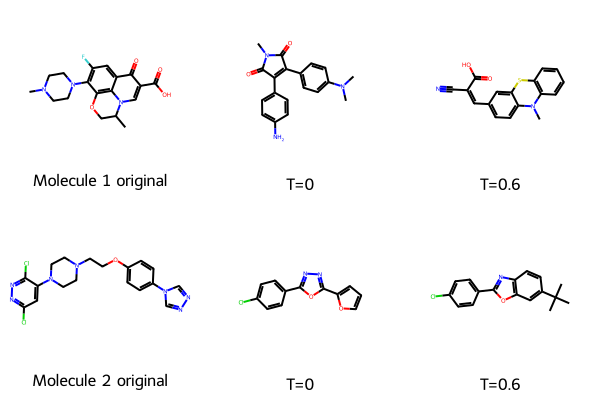

In [44]:
#originals
m1o=Chem.MolFromSmiles(test_string[0])
m2o=Chem.MolFromSmiles(test_string[1])
#T = 0
m1=Chem.MolFromSmiles(nm1)
m2=Chem.MolFromSmiles(nm2)
#T = ?
m1t=Chem.MolFromSmiles(ntm1)
m2t=Chem.MolFromSmiles(ntm2)

tstring = "T="+str(temp)
leglist = ["Molecule 1 original","T=0",tstring,"Molecule 2 original","T=0",tstring]

Draw.MolsToGridImage([m1o,m1,m1t,m2o,m2,m2t],molsPerRow=3,legends=leglist)

## Create specific vocab list

- First block must be run before using this block. Then swap out the old vocab file for the new one and rerun
first block.
- reads in original vocab list
- uses the fl2set from the first block: this is a set with all unique tokens used in this model
- if a token is used, it is added to the new vocab list
- Note: [unused] must be added after [PAD] if it is not included

In [13]:
#routine to create a smaller vocab_file based on the dataset using fl2set
#oldvocab = open("vocab.txt","r")
#oldvocab_lines = oldvocab.readlines()
#oldvocab.close()

#newvocab = open("vocab_new.txt","w",newline="\n")

#for i in range(len(oldvocab_lines)):
#    if i in fl2set:
#        print(oldvocab_lines[i])
#        newvocab.write(oldvocab_lines[i])

#newvocab.close()